In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn import preprocessing
import xgboost
from xgboost import XGBClassifier
import shap
import seaborn as sns
import yaml
import joblib

from scripts.check_overlaps import check_overlaps
from make_dataset import make_dataset_censored,  make_dataset_uncensored, repeat_masker, COSMIC_CGC_interactions, TF_binding_site_annotations, create_vep_input, read_vcf, long_range_interactions_results, create_vep_input, read_vcf, clean_and_preprocess

with open("configuration.yaml", "r") as yml_file:
    config = yaml.load(yml_file, yaml.Loader)

c:\ProgramData\anaconda3\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\ProgramData\anaconda3\envs\ensemble\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(

In [2]:
make_dataset_uncensored()

Calling UCSC Genome Browser API to extract end coordinates. This may take some time...
Extraction complete!


In [8]:
traindf = pd.read_csv('data/dataset_uncensored.csv')
testdf = pd.read_csv('data/test_data_final.csv')
testdf.drop(['region_type', 'reg_id'], inplace=True, axis=1)
df = pd.concat([traindf, testdf])
df

,id,chr,start,end,ref,alt,driver,data_source
0,mut0,3,101578254,101578255,CAGTT,C,1,ICGC
1,mut1,3,101578285,101578286,GACCATTTGCCTT,G,1,ICGC
2,mut2,3,101578250,101578251,CTG,C,1,ICGC
3,mut3,17,48940015,48940016,CTAAAT,C,1,ICGC
4,mut4,17,48939986,48939987,AT,A,1,ICGC
...,...,...,...,...,...,...,...,...
1057,test1116,9,125026995,125026996,C,G,1,Dr.Nod 2023
1058,test1117,9,124049461,124049462,T,A,1,Dr.Nod 2023
1059,test1118,X,70338403,70338404,G,A,1,Dr.Nod 2023
1060,test1119,X,70401837,70401838,G,T,1,Dr.Nod 2023


In [10]:
df.to_csv('data/all_data.csv', index=False)

In [32]:
df = pd.read_csv('data/dataset_uncensored.csv')
df = repeat_masker(df, 'train')
df = COSMIC_CGC_interactions(df, 'train')
df = TF_binding_site_annotations(df, 'train')
df = long_range_interactions_results(df, 'train')
df

,chr,start,ref,alt,id,end,driver,data_source,DNA,LINE,...,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff,CTCF_interactions,CTCF_chains,POLR2A_interactions,POLR2A_chains
0,1,1342375,A,G,mut943,1342375,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,54.619893,41.341490,57.633210,39.285036
1,1,2489274,G,A,mut245,2489274,1,ICGC,0,0,...,0,0,0.0,1.0,0.000000,0.934233,39.560328,30.289763,12.907330,9.104667
2,1,2492155,T,A,mut244,2492155,1,ICGC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,63.792107,48.198916,28.735503,19.477848
3,1,16477460,T,C,mut124,16477460,1,ICGC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,78.777731,59.220464,42.377556,29.176926
4,1,19114389,G,A,mut976,19114389,0,COSMIC,0,0,...,0,0,2.0,0.0,1.025076,0.000000,6.911249,4.823392,5.802829,3.385053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085,X,142919453,A,G,mut866,142919453,0,COSMIC,0,1,...,0,0,0.0,0.0,0.000000,0.000000,1.249834,0.792728,0.000064,0.000064
1086,X,145999464,G,T,mut836,145999464,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,0.001583,0.001200,0.000128,0.000128
1087,X,148496412,G,T,mut661,148496412,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,0.000026,0.000026,0.000000,0.000000
1088,X,152710276,C,T,mut927,152710276,0,COSMIC,0,0,...,0,0,0.0,0.0,0.000000,0.000000,5.973369,3.836056,0.000192,0.000192


In [5]:
ndf = pd.read_csv('data/nondriver_noncoding_mutations.vcf', sep='\t', header=None)
ndf.columns = ['chr', 'pos', 'ref', 'alt']
# df = repeat_masker(df, 'train')
# df = COSMIC_CGC_interactions(df, 'train')
# df = TF_binding_site_annotations(df, 'train')
# df = long_range_interactions_results(df, 'train')
ndf

,chr,pos,ref,alt
0,16,731865,C,T
1,10,51622545,G,T
2,22,50945191,T,C
3,5,149829722,G,T
4,22,45128174,G,A
...,...,...,...,...
1594,3,53899314,C,T
1595,1,187987238,A,G
1596,3,104266652,T,A
1597,19,36506373,C,T


In [33]:
df_test = pd.read_csv('data/test_data_final.csv')
df_test = repeat_masker(df_test, 'test')
df_test = COSMIC_CGC_interactions(df_test, 'test')
df_test = TF_binding_site_annotations(df_test, 'test')
df_test = long_range_interactions_results(df_test, 'test')
df_test

,chr,start,ref,alt,end,region_type,reg_id,data_source,id,driver,...,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff,CTCF_interactions,CTCF_chains,POLR2A_interactions,POLR2A_chains
0,1,2267093,C,T,2267093,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test30,1,...,0,0,1.0,0.0,6.012478,0.000000,0.0,0.0,0.0,0.0
1,1,2267139,G,A,2267139,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test3,1,...,0,0,1.0,0.0,1.587495,0.000000,0.0,0.0,0.0,0.0
2,1,2267211,C,T,2267211,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test29,1,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,1,2267473,C,T,2267473,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test36,1,...,0,0,2.0,0.0,1.041296,0.000000,0.0,0.0,0.0,0.0
4,1,2267569,G,A,2267569,enhancers.bed,enhancers::chr1:2267000-2269600::NA::NA,Rheinbay et al 2020,test37,1,...,0,0,0.0,2.0,0.000000,2.008131,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059,9,125026995,C,G,125026996,Breast,MRRF,Dr.Nod 2023,test1116,1,...,0,0,2.0,1.0,1.541926,1.120268,0.0,0.0,0.0,0.0
1060,9,125027081,C,G,125027082,Breast,MRRF,Dr.Nod 2023,test1114,1,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1061,X,70338403,G,A,70338404,Brain,MED12,Dr.Nod 2023,test1118,1,...,0,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1062,X,70365659,G,A,70365660,Brain,MED12,Dr.Nod 2023,test1120,1,...,0,0,0.0,2.0,0.000000,1.704271,0.0,0.0,0.0,0.0


Check and remove any rows from validation data set if they exist in our original dataset

In [34]:
duplicate_rows = df_test[(df_test['start'].isin(df['start'])) & (df_test['end'].isin(df['end'])) & (df_test['chr'].isin(df['chr'])) & (df_test['ref'].isin(df['ref'])) & (df_test['alt'].isin(df['alt']))].index
df_test = df_test.drop(duplicate_rows).reset_index(inplace=False)

Creating the input file for VEP<br>
This file is then given to Ensembl VEP <br>
We used the web version: https://grch37.ensembl.org/Homo_sapiens/Tools/VEP/<br>
Make sure you are using the Grch37 version

In [ ]:
df = create_vep_input(df, "data/VEP/vep_input.vcf")

In [ ]:
test_df_vcf = create_vep_input(df_test, "data/VEP/vep_input_test.vcf")

Reading VEP output<br>
The file generated by Ensembl VEP is downloaded (in .txt format) and used

In [35]:
df_vep_output = read_vcf('data/VEP/vep_output.txt')
df_vep_output_test = read_vcf('data/VEP/vep_output_test.txt')

Clean and preprocess the data

In [36]:
df_vep_output = clean_and_preprocess(df_vep_output)
df_vep_output_test = clean_and_preprocess(df_vep_output_test)

In [37]:
data = df_vep_output.merge(df, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data_test = df_vep_output_test.merge(df_test, left_on=['#Uploaded_variation'], right_on=['id'], how='right')
data.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test.drop(['#Uploaded_variation', 'Location'],inplace = True, axis = 1)
data_test

,Allele,SYMBOL,STRAND,ENSP,UNIPARC,GO,SpliceAI_pred_DP_AG,SpliceAI_pred_DP_AL,SpliceAI_pred_DP_DG,SpliceAI_pred_DP_DL,...,known_driver_gene_2kb_downstream,known_driver_gene_2kb_upstream,TF_loss,TF_gain,TF_loss_diff,TF_gain_diff,CTCF_interactions,CTCF_chains,POLR2A_interactions,POLR2A_chains
0,T,MORN1,0,1,1,1,0.0,36.0,0.0,0.0,...,0,0,1.0,0.0,6.012478,0.000000,0.0,0.0,0.0,0.0
1,A,MORN1,0,1,1,1,0.0,0.0,0.0,0.0,...,0,0,1.0,0.0,1.587495,0.000000,0.0,0.0,0.0,0.0
2,T,MORN1,0,1,1,1,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,T,MORN1,0,1,1,1,37.0,3.0,4.0,26.0,...,0,0,2.0,0.0,1.041296,0.000000,0.0,0.0,0.0,0.0
4,A,MORN1,0,1,1,1,33.0,0.0,24.0,0.0,...,0,0,0.0,2.0,0.000000,2.008131,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,G,MRRF,1,9,8,6,0.0,0.0,0.0,0.0,...,0,0,2.0,1.0,1.541926,1.120268,0.0,0.0,0.0,0.0
1013,G,MRRF,1,9,8,6,0.0,0.0,0.0,0.0,...,0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1014,A,MED12,1,4,4,36,0.0,0.0,0.0,0.0,...,0,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1015,A,MED12,1,7,7,76,0.0,0.0,0.0,0.0,...,0,0,0.0,2.0,0.000000,1.704271,0.0,0.0,0.0,0.0


In [38]:
data = data.drop(list(set(data.columns) - set(data_test.columns)), axis = 1)
data_test = data_test.drop(list(set(data_test.columns) - set(data.columns)), axis = 1)

In [40]:
data = data.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

data.to_csv('data/final_dataset.csv', index = False)
data_test.to_csv('data/final_dataset_test.csv', index = False)

In [45]:
data = pd.read_csv('data/final_dataset.csv')
data_test = pd.read_csv('data/final_dataset_test.csv')

# XGBoost

In [2]:
data = pd.read_csv('data/final_dataset.csv')
data_test = pd.read_csv('data/final_dataset_test.csv')

neg_add_in_validation = data[data['data_source'] == 'COSMIC'].sample(n=112)
data_test = pd.concat([data_test, neg_add_in_validation]).reset_index(drop=True)
data = data.drop(neg_add_in_validation.index, inplace=False).reset_index(drop=True, inplace=False)

for col in data.columns[data.isna().any()].tolist():
    data[col].fillna(0, inplace=True)

data['TF_binding_site_agg'] = np.logical_or(data['TF_binding_site'], data['TF_binding_site_variant']).astype(int)

data['TF_loss_add'] = data['TF_binding_site_agg'] + data['TF_loss']
data['TF_gain_add'] = data['TF_binding_site_agg'] + data['TF_gain']
data['TF_loss_diff_add'] = data['TF_binding_site_agg'] + data['TF_loss_diff']
data['TF_gain_diff_add'] = data['TF_binding_site_agg'] + data['TF_gain_diff']

data['SpliceAI_pred_DP_AG'] = abs(data['SpliceAI_pred_DP_AG'])
data['SpliceAI_pred_DP_AL'] = abs(data['SpliceAI_pred_DP_AL'])
data['SpliceAI_pred_DP_DG'] = abs(data['SpliceAI_pred_DP_DG'])
data['SpliceAI_pred_DP_DL'] = abs(data['SpliceAI_pred_DP_DL'])


for col in data_test.columns[data_test.isna().any()].tolist():
    data_test[col].fillna(0, inplace=True)
    
data_test['TF_binding_site_agg'] = np.logical_or(data_test['TF_binding_site'], data_test['TF_binding_site_variant']).astype(int)

data_test['TF_loss_add'] = data_test['TF_binding_site_agg'] + data_test['TF_loss']
data_test['TF_gain_add'] = data_test['TF_binding_site_agg'] + data_test['TF_gain']
data_test['TF_loss_diff_add'] = data_test['TF_binding_site_agg'] + data_test['TF_loss_diff']
data_test['TF_gain_diff_add'] = data_test['TF_binding_site_agg'] + data_test['TF_gain_diff']

data_test['SpliceAI_pred_DP_AG'] = abs(data_test['SpliceAI_pred_DP_AG'])
data_test['SpliceAI_pred_DP_AL'] = abs(data_test['SpliceAI_pred_DP_AL'])
data_test['SpliceAI_pred_DP_DG'] = abs(data_test['SpliceAI_pred_DP_DG'])
data_test['SpliceAI_pred_DP_DL'] = abs(data_test['SpliceAI_pred_DP_DL'])

In [3]:
XGB_PARAMS = {                                            # CODE SOURCE: containers_build\boostdm\config.py
        "objective": "binary:logistic",
        "reg_lambda": 1,
        "random_state": 42,
        "scale_pos_weight": 1,
        "subsample": 0.7,        # fraction of observations to be random samples for each tree
        "reg_alpha": 0,          # L1 regularization term on weight
        "max_delta_step": 0,    # positive value can help make the update step more conservative. generally not used
        "min_child_weight": 1,
        "learning_rate": 1e-03,
        "colsample_bylevel": 1.0,
        "gamma": 0,     # specifies the minimum loss reduction required to make a split. Makes the algorithm conservative
        "colsample_bytree": 1.0,        # fraction of columns to be random samples for each tree
        "booster": "gbtree",
        "max_depth": 4, # Used to control over-fitting as higher depth will allow the model to learn relations very specific to a particular sample
        "silent": 1,
        "seed": 21,
        "eval_metric": 'logloss',
        "early_stopping_rounds": 2000
        # "reg_lambda": 1,  # explore this further

}

COLUMNS_TRAINING = config['COLUMNS_TRAINING']

BIASED_COLUMNS = ['chr', 'ref_x', 'IG_C_gene', 'IG_D_gene', 'IG_J_gene', 'IG_J_pseudogene']

COLUMNS_TRAINING = [x for x in COLUMNS_TRAINING if x not in BIASED_COLUMNS]

COLUMNS_SHAP = [f'my_shap_{x}' for x in COLUMNS_TRAINING]

for col in list(set(COLUMNS_TRAINING) - set(data.columns)):
    data[col] = 0

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))

data[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data[COLUMNS_TRAINING])

for col in list(set(COLUMNS_TRAINING) - set(data_test.columns)):
    data_test[col] = 0

data_test[COLUMNS_TRAINING] = min_max_scaler.fit_transform(data_test[COLUMNS_TRAINING])

# Simple run

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data[COLUMNS_TRAINING], data['driver'],
                                                    random_state=104, 
                                                    test_size=0.25, 
                                                    shuffle=True)

x_train, x_val, y_train, y_val = train_test_split(x_train[COLUMNS_TRAINING], y_train,
                                                    random_state=104, 
                                                    test_size=0.10, 
                                                    shuffle=True)

print('Train set:', len(x_train), 'records')
print('Test set:', len(x_test), 'records')
print('Validation set:', len(x_val), 'records')

Train set: 657 records
Test set: 244 records
Validation set: 73 records


In [106]:
params = XGB_PARAMS.copy()                                          
params['n_estimators'] = 20000  # set it high enough to allow "early stopping" events below
params['base_score'] = y_train.mean()
params['silent'] = True
# params['n_jobs'] = 1
params['seed'] = 104
model = XGBClassifier(**params)

# train with xgboost
# learning_curve_dict = {}
model.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
                    callbacks = [
                        xgboost.callback.EvaluationMonitor(rank=0, period=1, show_stdv=False)
                    ],
                    verbose = 0)

params['n_estimators'] = model.best_iteration
model.set_params(**params)

[17296]	validation_0-logloss:0.02315	validation_1-logloss:0.05822
[17297]	validation_0-logloss:0.02315	validation_1-logloss:0.05822
[17298]	validation_0-logloss:0.02315	validation_1-logloss:0.05822
[17299]	validation_0-logloss:0.02314	validation_1-logloss:0.05822
[17300]	validation_0-logloss:0.02314	validation_1-logloss:0.05822
[17301]	validation_0-logloss:0.02314	validation_1-logloss:0.05821
[17302]	validation_0-logloss:0.02314	validation_1-logloss:0.05821
[17303]	validation_0-logloss:0.02314	validation_1-logloss:0.05821
[17304]	validation_0-logloss:0.02314	validation_1-logloss:0.05821
[17305]	validation_0-logloss:0.02313	validation_1-logloss:0.05821
[17306]	validation_0-logloss:0.02313	validation_1-logloss:0.05821
[17307]	validation_0-logloss:0.02313	validation_1-logloss:0.05821
[17308]	validation_0-logloss:0.02313	validation_1-logloss:0.05821
[17309]	validation_0-logloss:0.02313	validation_1-logloss:0.05820
[17310]	validation_0-logloss:0.02312	validation_1-logloss:0.05820
[17311]	va

XGBClassifier(base_score=0.5114155251141552, booster='gbtree', callbacks=None,
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=2000,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=4,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=19995, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

Storing and Loading Model

In [6]:
filename = 'trained_model.sav'

model = joblib.load(filename)

# joblib.dump(model, filename)

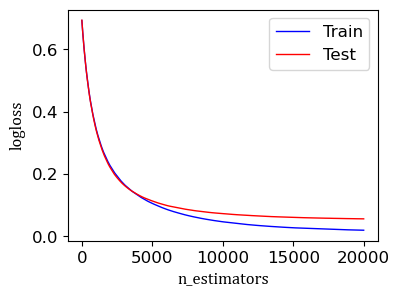

In [110]:
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train', color='blue', linewidth = '1')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test', color='red', linewidth = '1')
ax.legend()
plt.ylabel('logloss',{'fontname':'Cambria'})
plt.xlabel('n_estimators',{'fontname':'Cambria'})
# plt.title('XGBoost logloss', {'fontname':'Cambria'})
plt.show()

In [111]:
y_pred = model.predict(x_test)
score = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(y_pred, y_test))
print('precision: ', precision_score(y_test, y_pred))
print('recall: ' , recall_score(y_test, y_pred))
print('f1_score: ', f1_score(y_test, y_pred))
print('roc_auc_score: ', roc_auc_score(y_test, y_pred))

Accuracy: 0.980
Log-loss: 0.739
precision:  0.967479674796748
recall:  0.9916666666666667
f1_score:  0.9794238683127573
roc_auc_score:  0.9797043010752688


Test-Set Confusion Matrix

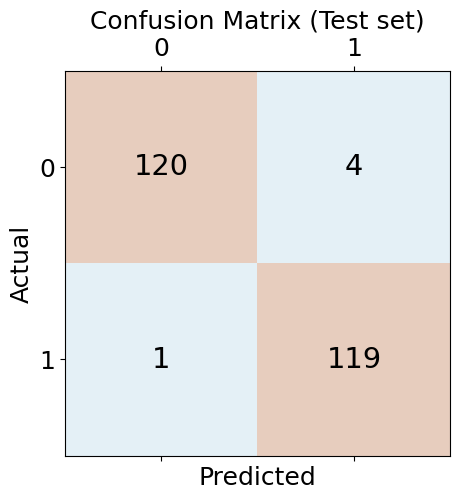

In [112]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Test set)', fontsize=18)
plt.show()

In [63]:
valsetpred = model.predict(x_val[COLUMNS_TRAINING])
# print(valset['driver'])
# print(valsetpred)
score = accuracy_score(y_val, valsetpred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(valsetpred, y_val))
print('precision: ', precision_score(y_val, valsetpred))
print('recall: ' , recall_score(y_val, valsetpred))
print('f1_score: ', f1_score(y_val, valsetpred))

Accuracy: 0.932
Log-loss: 2.469
precision:  0.9117647058823529
recall:  0.9393939393939394
f1_score:  0.9253731343283583


Validation-Set Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=y_val, y_pred=valsetpred)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Validation set)', fontsize=18)
plt.show()

Rheinbay Confusion Matrix

Accuracy: 0.597
Log-loss: 14.541
precision:  0.9868421052631579
recall:  0.5487804878048781
f1_score:  0.7053291536050156
roc_auc_score:  0.7476045296167247


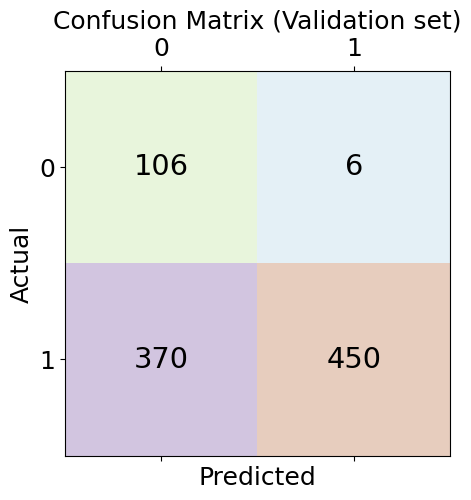

In [113]:
valsetpred = model.predict(data_test[data_test['data_source'] != 'Dr.Nod 2023'][COLUMNS_TRAINING])
valset_y = data_test[data_test['data_source'] != 'Dr.Nod 2023']['driver']
score = accuracy_score(valset_y, valsetpred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(valsetpred, valset_y))
print('precision: ', precision_score(valset_y, valsetpred))
print('recall: ' , recall_score(valset_y, valsetpred))
print('f1_score: ', f1_score(valset_y, valsetpred))
print('roc_auc_score: ', roc_auc_score(valset_y, valsetpred))

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=valset_y, y_pred=valsetpred)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Validation set)', fontsize=18)
plt.show()

Dr.Nod Confusion Matrix

Accuracy: 0.806
Log-loss: 6.999
precision:  0.959731543624161
recall:  0.7258883248730964
f1_score:  0.8265895953757225
roc_auc_score:  0.8361584481508338


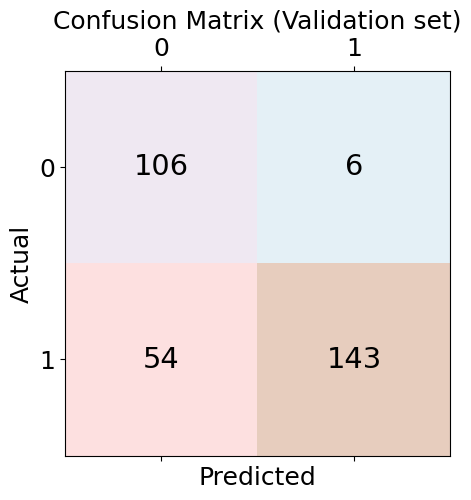

In [115]:
valsetpred = model.predict(data_test[data_test['data_source'] != 'Rheinbay et al 2020'][COLUMNS_TRAINING])
valset_y = data_test[data_test['data_source'] != 'Rheinbay et al 2020']['driver']
score = accuracy_score(valset_y, valsetpred)
print('Accuracy: %.3f' % score)
print('Log-loss: %.3f' % log_loss(valsetpred, valset_y))
print('precision: ', precision_score(valset_y, valsetpred))
print('recall: ' , recall_score(valset_y, valsetpred))
print('f1_score: ', f1_score(valset_y, valsetpred))
print('roc_auc_score: ', roc_auc_score(valset_y, valsetpred))

from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_true=valset_y, y_pred=valsetpred)

plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Paired, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Actual', fontsize=18)
plt.title('Confusion Matrix (Validation set)', fontsize=18)
plt.show()

In [20]:
from random import seed
from random import randrange
 
# zero rule algorithm for classification
def zero_rule_algorithm_classification(train, test):
 output_values = [row[-1] for row in train]
 prediction = max(set(output_values), key=output_values.count)
 predicted = [prediction for i in range(len(test))]
 return predicted

train = x_train
train['driver'] = y_train
test = x_test
test['driver'] = y_test
seed(1)
# train = [['0'], ['0'], ['0'], ['0'], ['1'], ['1']]
# test = [[None], [None], [None], [None]]
predictions = zero_rule_algorithm_classification(train, test)
print(predictions)

['t', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't', 't',

In [ ]:
valset = data_test.copy()
valset['driver'] = data_test['driver']
valset['predicted'] = valsetpred
valset['result'] = np.where(valset['driver'] == valset['predicted'], 'correct', 'wrong')
valset[['result', 'data_source']].value_counts()

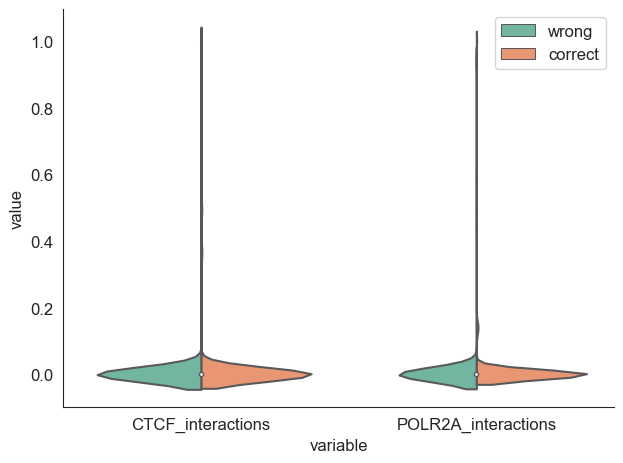

In [44]:
meltdf = valset[['CTCF_interactions', 'POLR2A_interactions', 'driver', 'result']].melt(id_vars=['result'], value_vars=['CTCF_interactions', 'POLR2A_interactions'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

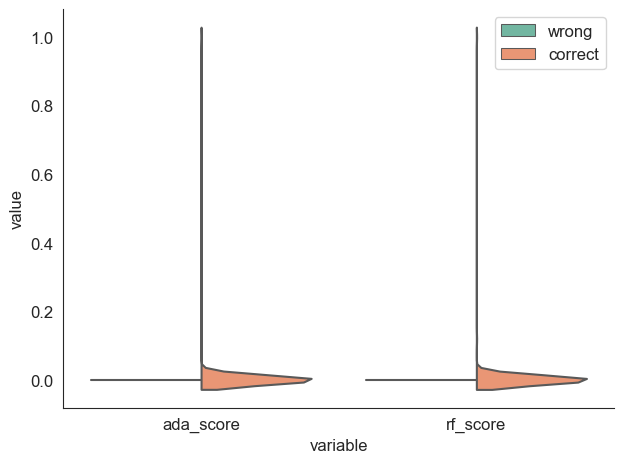

In [45]:
meltdf = valset[['ada_score', 'rf_score', 'driver', 'result']].melt(id_vars=['result'], value_vars=['ada_score', 'rf_score'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

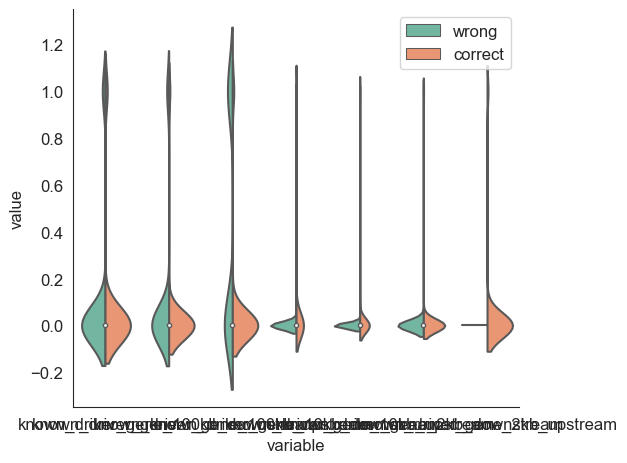

In [49]:
meltdf = valset[['known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream','known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream', 'driver', 'result']].melt(id_vars=['result'], value_vars=['known_driver_gene', 'known_driver_gene_100kb_downstream', 'known_driver_gene_100kb_upstream', 'known_driver_gene_10kb_downstream','known_driver_gene_10kb_upstream', 'known_driver_gene_2kb_downstream', 'known_driver_gene_2kb_upstream',])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

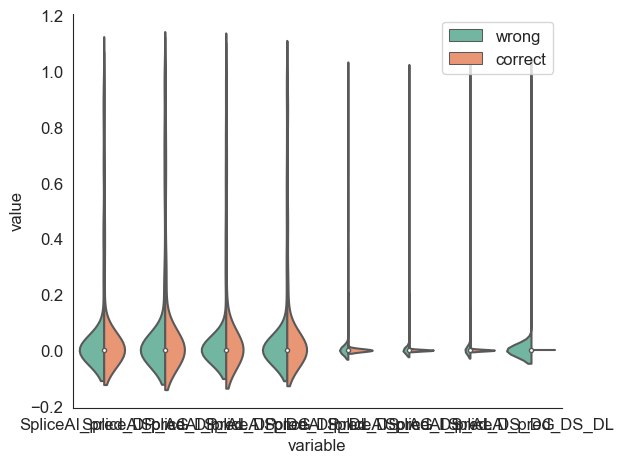

In [50]:
meltdf = valset[['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL', 'driver', 'result']].melt(id_vars=['result'], value_vars=['SpliceAI_pred_DP_AG', 'SpliceAI_pred_DP_AL',
                    'SpliceAI_pred_DP_DG', 'SpliceAI_pred_DP_DL', 'SpliceAI_pred_DS_AG',
                    'SpliceAI_pred_DS_AL', 'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL'])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

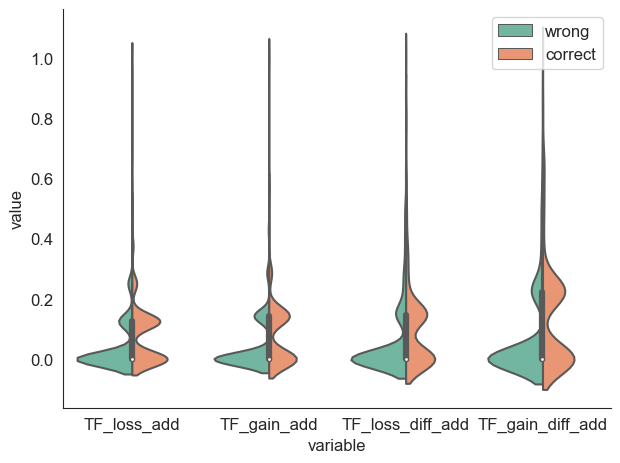

In [67]:
meltdf = valset[['TF_loss_add', 'TF_gain_add', 'TF_loss_diff_add', 'TF_gain_diff_add', 'driver', 'result']].melt(id_vars=['result'], value_vars=['TF_loss_add', 'TF_gain_add', 'TF_loss_diff_add', 'TF_gain_diff_add',])
sns.set_style('white')
ax = sns.violinplot(data=meltdf, x='variable', y='value', hue='result', split=True, palette='Set2')
ax.legend()
sns.despine()
plt.tight_layout()
plt.show()

SHAP Explainer

In [7]:
x_data = data[COLUMNS_TRAINING]
x_data = x_data.reindex(columns=COLUMNS_TRAINING)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_data)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [8]:
for c in COLUMNS_SHAP:
    data[c] = np.nan
data.loc[data.index, COLUMNS_SHAP] = shap_values

In [21]:
# x_data[['splice_acceptor_variant', 'splice_donor_variant', 'promoter', 'downstream_gene_variant', 'regulatory_region_variant']]#.describe()
x_data.columns.get_loc('downstream_gene_variant')
# x_data.columns.get_loc('TF_loss_add')
# x_data.columns.get_loc('LOEUF')
# data['driver'].value_counts()

17

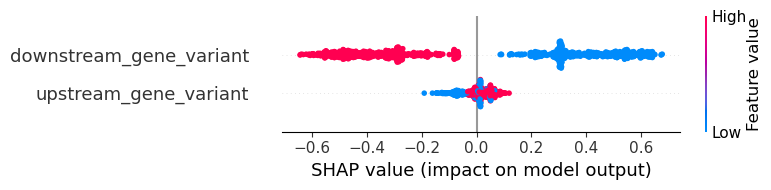

In [22]:
# shap.summary_plot(shap_values[:,2:5], x_data.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values[:,6:14], x_data.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values[:,0:2], x_data.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
# shap.summary_plot(shap_values[:,39:43], x_data.iloc[:, 39:43], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values[:,[48, 50, 51, 52, 53, 54, 49]], x_data.iloc[:, [48, 50, 51, 52, 53, 54, 49]], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values[:,43:48], x_data.iloc[:, 43:48], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values[:,65:70], x_data.iloc[:, 65:70], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values[:,5:6], x_data.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values[:,[60, 55, 24, 38, 17, 23]], x_data.iloc[:, [60, 55, 24, 38, 17, 23]], plot_size = 0.25) # the rest
shap.summary_plot(shap_values[:,[17, 25]], x_data.iloc[:, [17, 25]], plot_size = 0.25) # the rest

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


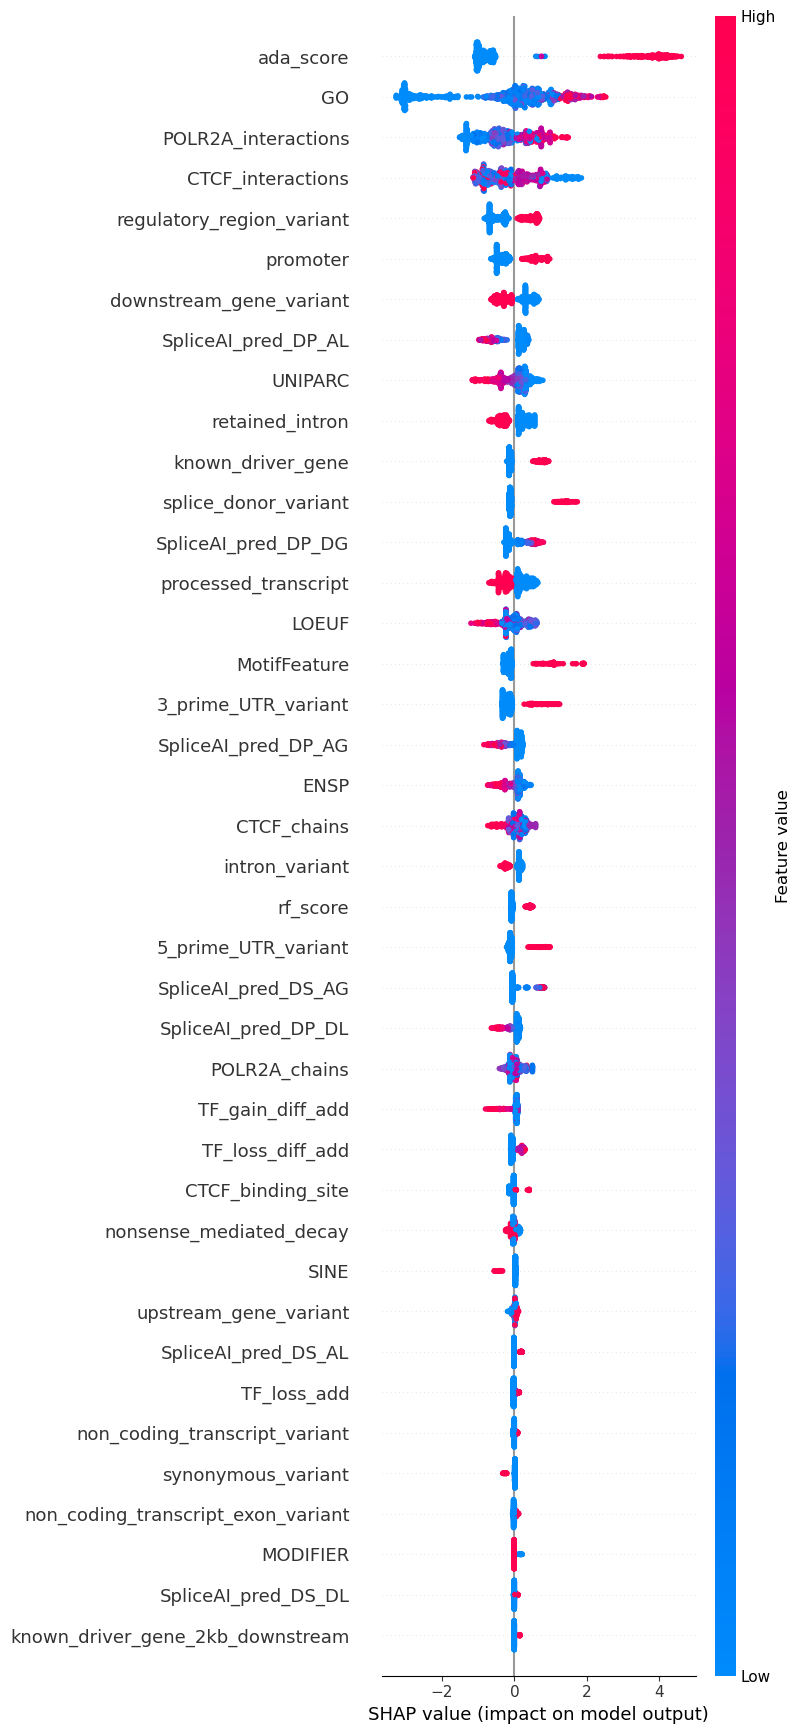

In [119]:
shap.summary_plot(shap_values, x_data, max_display=40)

In [ ]:
# shap.dependence_plot("CTCF_interactions", shap_values, x_data, interaction_index="CTCF_chains")
shap.plots.violin(shap_values, feature_names=list(data[COLUMNS_TRAINING].columns), plot_type="violin")

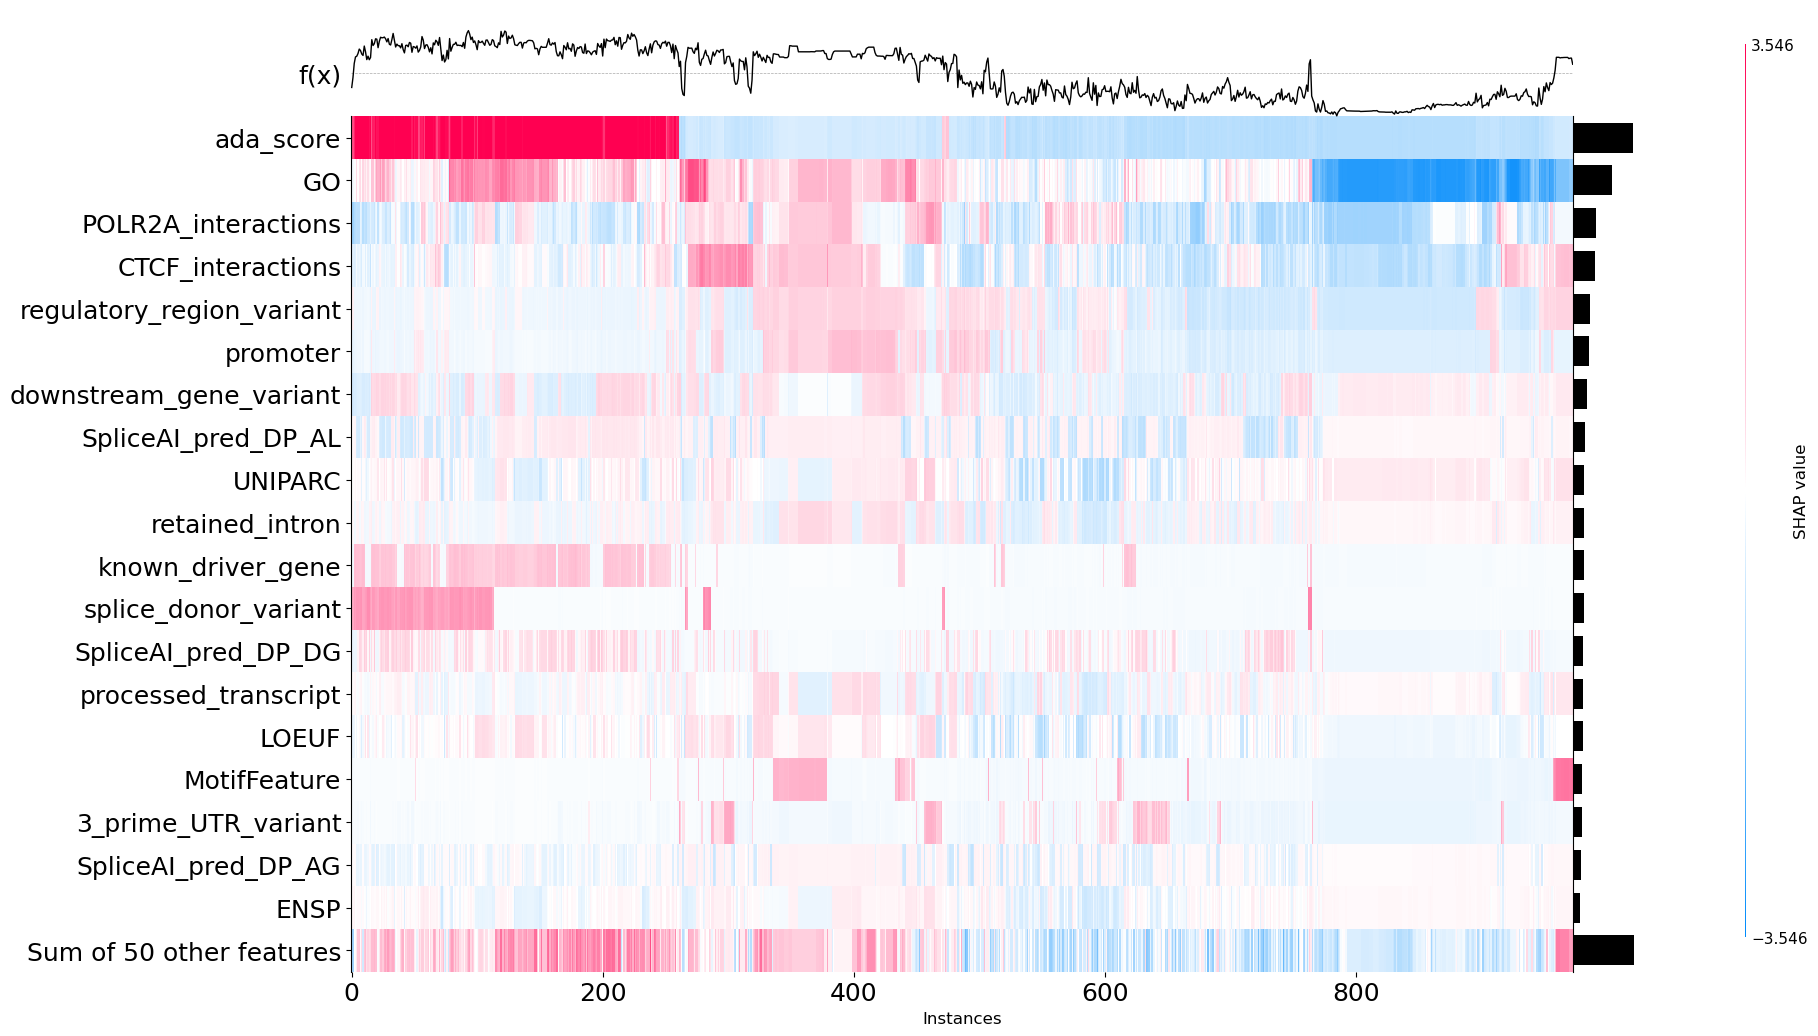

In [121]:
# shap.plots.heatmap(shap_values)
plt.rcParams.update({'font.size': 12})
shap_values_explaination = shap.Explanation(shap_values, feature_names=data[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination, max_display=20, plot_width=18, show=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [68]:
x_data = data[COLUMNS_TRAINING]
explainer = shap.TreeExplainer(model) # grabbing the first model
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[101:200], x_data[101:200])

<Axes: >

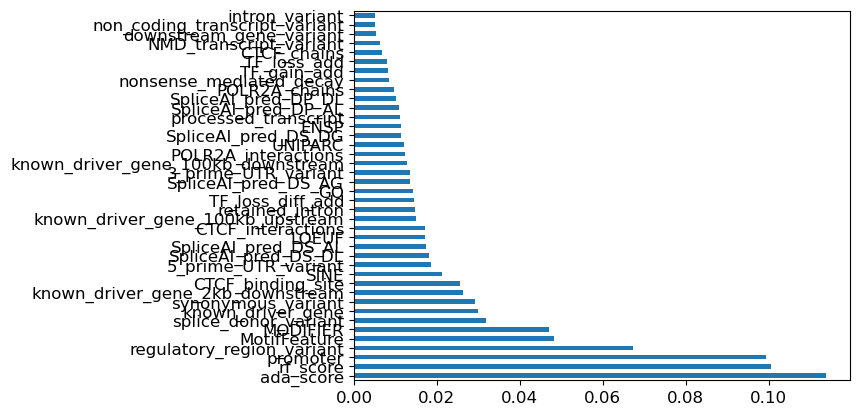

In [80]:
feat_importances = pd.Series(model.feature_importances_, index=data[COLUMNS_TRAINING].columns)
feat_importances.nlargest(40).plot(kind='barh')

SHAP for Validation Set

In [122]:
x_data_test = data_test[COLUMNS_TRAINING]
x_data_test = x_data_test.reindex(columns=COLUMNS_TRAINING)

explainer_test = shap.TreeExplainer(model)
shap_values_test = explainer_test.shap_values(x_data_test)

for c in COLUMNS_SHAP:
    data_test[c] = np.nan
data_test.loc[data_test.index, COLUMNS_SHAP] = shap_values_test

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


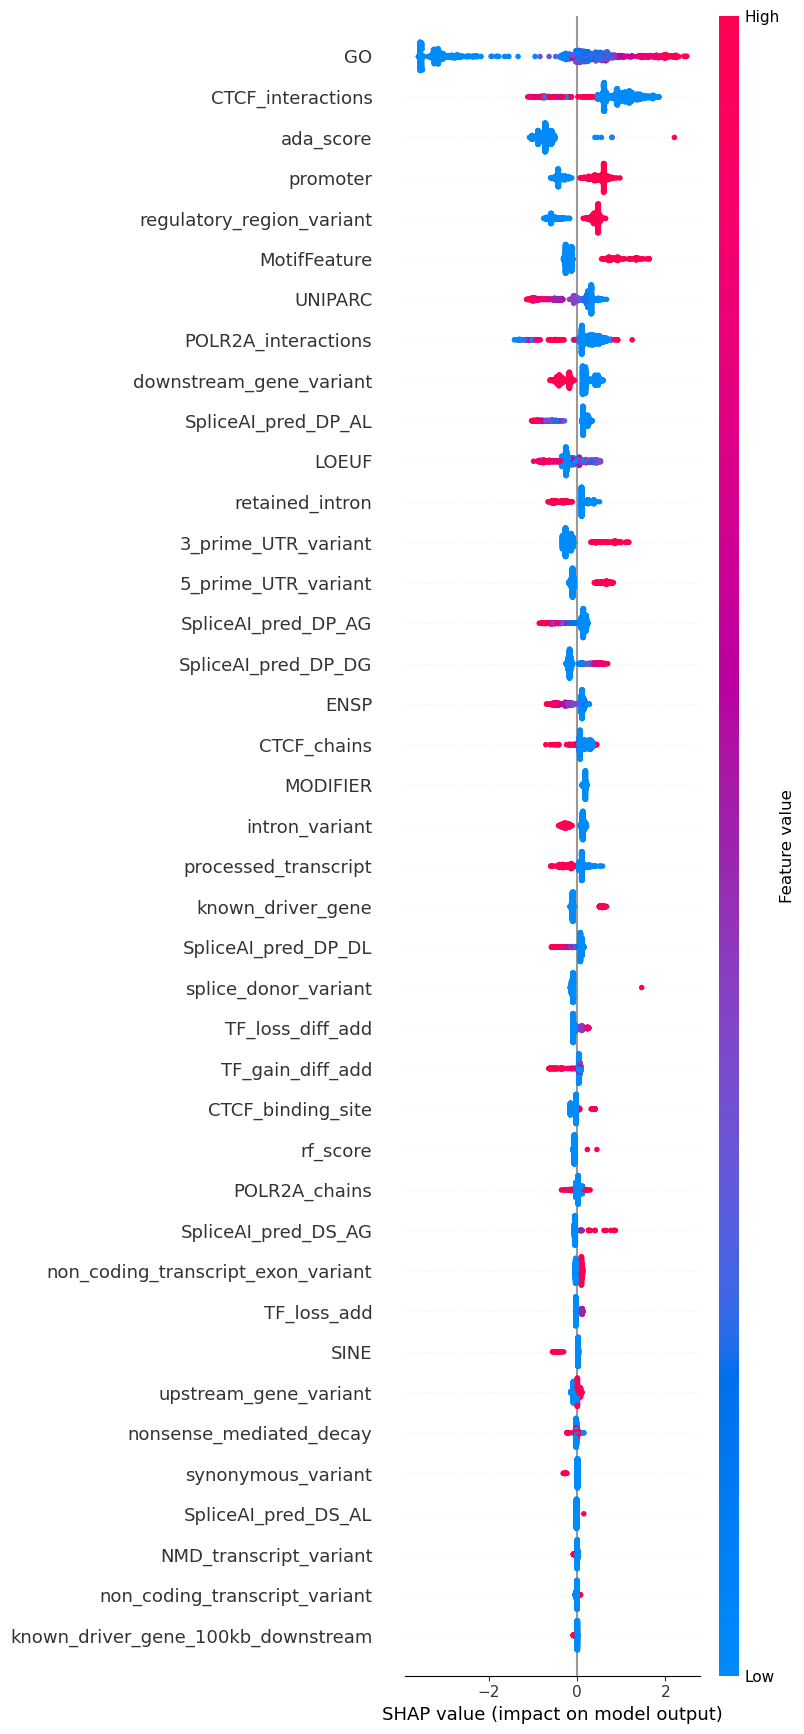

In [123]:
shap.summary_plot(shap_values_test, x_data_test, max_display=40)

In [83]:
data[data['driver'] == 0][['CTCF_interactions']].count()

CTCF_interactions    487
dtype: int64

In [66]:
data[data['driver'] == 1][['CTCF_interactions']].count()

CTCF_interactions    487
dtype: int64

In [5]:
data_test[['data_source']].value_counts()

data_source        
Rheinbay et al 2020    820
Dr.Nod 2023            197
COSMIC                 112
dtype: int64

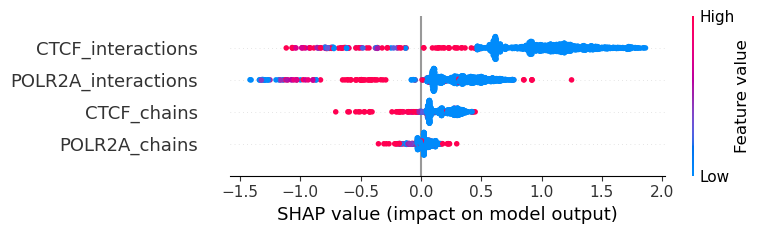

In [124]:
# shap.summary_plot(shap_values_test[:,2:5], x_data_test.iloc[:, 2:5], plot_size = 0.25)  # protein product
# shap.summary_plot(shap_values_test[:,6:14], x_data_test.iloc[:, 6:14], plot_size = 0.25)  # splice ai
# shap.summary_plot(shap_values_test[:,0:2], x_data_test.iloc[:, 0:2], plot_size = 0.25) #ada score rf score
shap.summary_plot(shap_values_test[:,39:43], x_data_test.iloc[:, 39:43], plot_size = 0.25)  # interactions
# shap.summary_plot(shap_values_test[:,[48, 50, 51, 52, 53, 54, 49]], x_data_test.iloc[:, [48, 50, 51, 52, 53, 54, 49]], plot_size = 0.25) # cosmic genes
# shap.summary_plot(shap_values_test[:,43:48], x_data_test.iloc[:, 43:48], plot_size = 0.25) #repeat masker
# shap.summary_plot(shap_values_test[:,65:70], x_data_test.iloc[:, 65:70], plot_size = 0.25)  # tf
# shap.summary_plot(shap_values_test[:,5:6], x_data_test.iloc[:, 5:6], plot_size = 0.25)  # loeuf
# shap.summary_plot(shap_values_test[:,[60, 24, 38, 17, 23]], x_data_test.iloc[:, [60, 24, 38, 17, 23]], plot_size = 0.25) # the rest

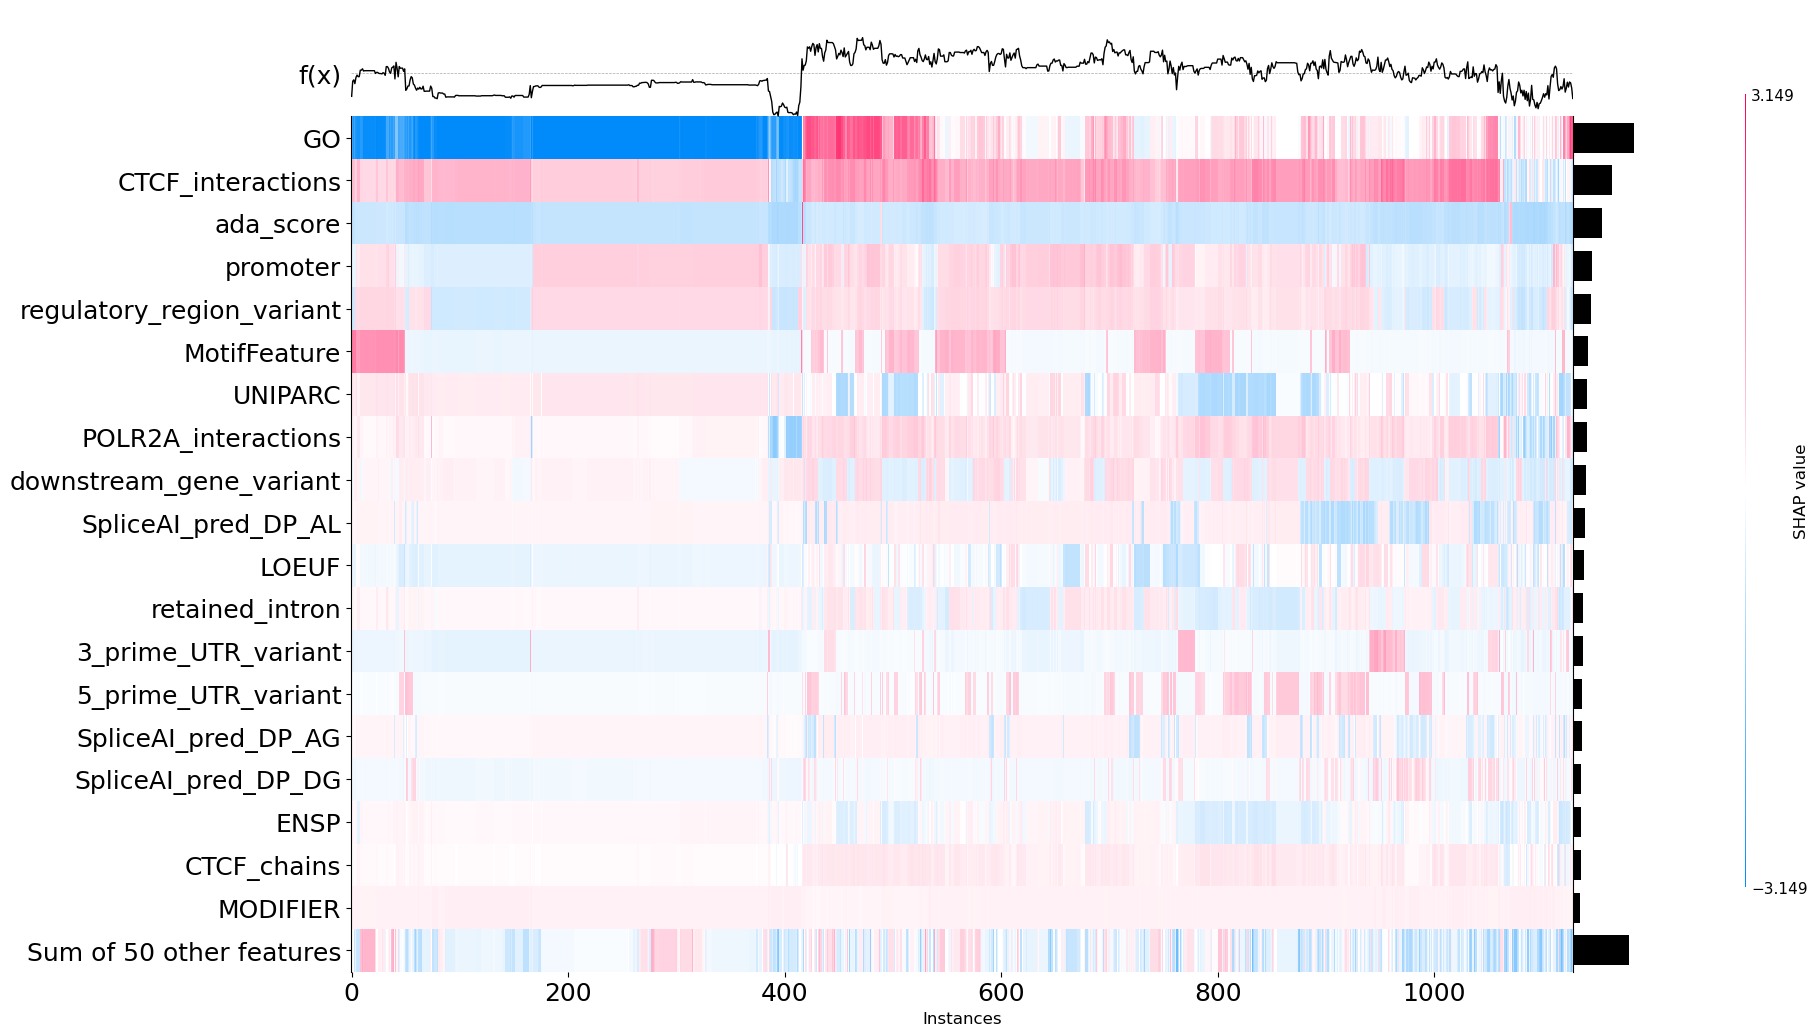

In [125]:
# shap.plots.heatmap(shap_values)
plt.rcParams.update({'font.size': 12})
shap_values_explaination_test = shap.Explanation(shap_values_test, feature_names=data_test[COLUMNS_TRAINING].columns.tolist()) 
shap.plots.heatmap(shap_values_explaination_test, max_display=20, plot_width=18, show=False)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [126]:
data['driver'].value_counts()

0    487
1    487
Name: driver, dtype: int64

In [127]:
len(data)

974